# Model LightGBM | Credit line

## Навигация

1. [Out-of-time и Train/Test разбивка](#Out-of-time-и-Train/Test-разбивка)
2. [Обучение](#Обучение)
   - [Оптимизация гиперпараметров с optuna](#Оптимизация-гиперпараметров-с-optuna)
   - [Refit](#Refit)
3. [поиск лучшего порога бинаризации](#поиск-лучшего-порога-бинаризации)
4. [Model perfomance](#Model-perfomance)
   - [Train perfomance](#Train-perfomance)
   - [Test perfomance](#Test-perfomance)
   - [Out-of-time perfomance](#Out-of-time-perfomance)
      - [January](#January)
      - [February](#February)
      - [March](#March)
      - [Out of time together](#Out-of-time-together)
5. [Gini OOT STD](#Gini-OOT-STD)      
6. [PSI](#PSI)
7. [SHAP values](#SHAP-values)

In [1]:
import joblib
import sys

sys.path.append("..")
import os

import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)
import shap

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

from feature_engine.selection import DropHighPSIFeatures

import utils
from utils.classification import my_binary_classification_report, psi_plot
from utils.business import approval_rate_plot
from utils.custom_column_transformers import GenAge, GenDataFromDatetime

import src
from src.data.cl_preprocess import foo_sex, foo_sitename, foo_dtype
from feature_engine.selection import DropHighPSIFeatures

from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve,
    CalibrationDisplay,
)

/home/ahmetov/credit-line/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ahmetov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
CLASSIFIER_NAME = "LightGBM GBDT"

RAW_DATA_PATH = os.path.join("..", "data", "raw", "raw.csv")

MODEL_PATH = os.path.join("..", "models", "req_amount", "lgbm.pkl")

CALIBRATED_MODEL_PATH = os.path.join(
    "..", "models", "calibrated", "calibrated_lgbm.pkl"
)

In [13]:
data = pd.read_csv(
    RAW_DATA_PATH,
    index_col="AppId",
    parse_dates=["dtstart", "birthday"],
    usecols=[
        # origin
        "AppId",
        "dtstart",
        "birthday",
        "sex",
        "citizenshipid",
        "martialid",
        "dependents",
        "sitename",
        "DOC",
        "averagemonthlyincome",
        "requested_amount",
        # nbki
        "Days_since_last_credit",
        "Max_overdue",
        # equifax
        "Nb_delays_90plus_ever_eq",
        "CH_length_eq",
        "S_hare_active_credit",
        # megafon/mail
        "Score",
        "MatchingLevel",
        "LIFETIMEBINValueId",
        "INTEGRALSCOREValueId",
        "60_6mob",
    ],
)

data = data.query('dtstart < "2023-09-01"')
data["60_6mob"] = data["60_6mob"].apply(
    lambda x: 0 if str(x) == "0.0" else 1
)  # Предобработка таргета

data = data.sort_values("dtstart")

data.head()

,dtstart,sex,birthday,citizenshipid,martialid,dependents,sitename,DOC,averagemonthlyincome,Days_since_last_credit,Max_overdue,Nb_delays_90plus_ever_eq,CH_length_eq,S_hare_active_credit,Score,MatchingLevel,INTEGRALSCOREValueId,LIFETIMEBINValueId,60_6mob,requested_amount
AppId,,,,,,,,,,,,,,,,,,,,
617650,2019-09-26 13:19:00,2.0,1960-11-08,860,3.0,0,www.maximus.ru,2.0,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.064780,5.0,0,13454.0
620164,2019-09-27 11:13:00,1.0,1988-07-10,762,1.0,0,www.maximus.ru,1.0,45000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.078340,5.0,0,19172.3
631492,2019-10-04 18:29:00,1.0,1989-02-14,762,2.0,1,www.megafon.ru,1.0,100000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.134316,4.0,0,12453.7
637036,2019-10-08 20:50:00,1.0,1995-07-10,762,1.0,0,www.megafon.ru,NaN,60000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.272594,1.0,0,23069.2
639263,2019-10-10 14:03:00,1.0,1990-10-30,762,2.0,1,www.megafon.ru,1.0,70000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.097222,5.0,0,26940.9


In [14]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 24486 entries, 617650 to 2265216
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   dtstart                   24486 non-null  datetime64[ns]
 1   sex                       24398 non-null  float64       
 2   birthday                  24486 non-null  datetime64[ns]
 3   citizenshipid             24486 non-null  int64         
 4   martialid                 24478 non-null  float64       
 5   dependents                24486 non-null  int64         
 6   sitename                  24486 non-null  object        
 7   DOC                       23007 non-null  float64       
 8   averagemonthlyincome      24486 non-null  int64         
 9   Days_since_last_credit    22113 non-null  float64       
 10  Max_overdue               22113 non-null  float64       
 11  Nb_delays_90plus_ever_eq  4027 non-null   float64       
 12  CH_length_eq    

## Out-of-time и Train/Test разбивка

[к навигации](#Навигация)

In [15]:
def get_X_y(df, index):
    X = df.loc[index].drop(
        columns=[
            "60_6mob",
        ]
    )
    y = df.loc[index, "60_6mob"]

    return X, y

In [16]:
# Out-of-time
other_index = data.query('"2021-08-01" <= dtstart < "2023-01-01"').index
january_index = data.query('"2023-01-01" <= dtstart < "2023-02-01"').index
february_index = data.query('"2023-02-01" <= dtstart < "2023-03-01"').index
march_index = data.query('"2023-03-01" <= dtstart < "2023-04-01"').index
oot_index = data.query('"2023-01-01" <= dtstart < "2023-04-01"').index

print(
    f'Размер обучающей выборки {other_index.shape[0]} '
    f'(доля дефолтников {data.loc[other_index, "60_6mob"].mean():.2%}).\n'
    f'Размер ЯНВАРЬской выборки {january_index.shape[0]} '
    f'(доля дефолтников {data.loc[january_index, "60_6mob"].mean():.2%}).\n'
    f'Размер ФЕВРАЛЬской выборки {february_index.shape[0]} '
    f'(доля дефолтников {data.loc[february_index, "60_6mob"].mean():.2%}).\n'
    f'Размер МАРТовской выборки {march_index.shape[0]} '
    f'(доля дефолтников {data.loc[march_index, "60_6mob"].mean():.2%}).\n'
    f'Размер OOT выборки {oot_index.shape[0]} '
    f'(доля дефолтников {data.loc[oot_index, "60_6mob"].mean():.2%}).\n'
)

Размер обучающей выборки 12330 (доля дефолтников 23.58%).
Размер ЯНВАРЬской выборки 624 (доля дефолтников 18.11%).
Размер ФЕВРАЛЬской выборки 500 (доля дефолтников 17.80%).
Размер МАРТовской выборки 406 (доля дефолтников 18.23%).
Размер OOT выборки 1530 (доля дефолтников 18.04%).



In [74]:
X, y = get_X_y(data, data.index)
X_train, y_train = get_X_y(data, other_index)
X_january, y_january = get_X_y(data, january_index)
X_february, y_february = get_X_y(data, february_index)
X_march, y_march = get_X_y(data, march_index)
X_oot, y_oot = get_X_y(data, oot_index)

In [8]:
# подгружаем веса модели

model = joblib.load(MODEL_PATH)
calibrated_model = joblib.load(CALIBRATED_MODEL_PATH)

## Обучение

[к навигации](#Навигация)

### Оптимизация гиперпараметров с optuna

[к навигации](#Навигация)

In [8]:
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""

    tss = TimeSeriesSplit(n_splits=10)
    auc_scores = np.zeros(10)
    for i, (t, v) in enumerate(tss.split(X_train, y_train)):
        model = get_model(trial, mode="fit")

        train_X = X_train.iloc[t]
        train_y = y_train.iloc[t]

        val_X = X_train.iloc[v]
        val_y = y_train.iloc[v]

        model.fit(
            train_X,
            train_y,
        )
        y_proba = model.predict_proba(val_X)[:, 1]

        auc_scores[i] = roc_auc_score(
            val_y,
            y_proba,
        )

    return auc_scores.mean()


def get_model(trial, mode):
    cat_cols = [
        "sex",
        "sitename",
        "citizenshipid",
        "martialid",
    ]

    level_1 = ColumnTransformer(
        [
            ("preprocess_sex", FunctionTransformer(foo_sex), "sex"),
            ("preprocess_sitename", FunctionTransformer(foo_sitename), "sitename"),
            ("gen_age", GenAge(), ["dtstart", "birthday"]),
            ("gen_datetime_data", GenDataFromDatetime(month=True), "dtstart"),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")

    level_2 = ColumnTransformer(
        [("preprocess_dtype", FunctionTransformer(foo_dtype), cat_cols)],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ).set_output(transform="pandas")

    preprocess_pipe = Pipeline([("step_1", level_1), ("step_2", level_2)])

    lgbm_model = lightgbm.LGBMClassifier(**get_lgbm_init_params(trial, mode), n_jobs=13)

    model = Pipeline(
        [
            ("preprocess", preprocess_pipe),
            # ('LGBM', lgbm_model),
            ("LGBM", CalibratedClassifierCV(lgbm_model)),
        ]
    )

    return model


def get_lgbm_init_params(trial, mode):
    if mode == "fit":
        n_estimators = trial.suggest_int("n_estimators", 100, 300)
        max_depth = trial.suggest_int("max_depth", 2, 6)
        learning_rate = trial.suggest_float("learning_rate", 0.05, 1.0, log=True)
        num_leaves = trial.suggest_int("num_leaves", 4, 64)
        min_child_samples = trial.suggest_int("min_child_samples", 20, 50)
        reg_alpha = trial.suggest_float("reg_alpha", 0, 3)
        reg_lambda = trial.suggest_float("reg_lambda", 0, 3)
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.01, 1.0)
        min_split_gain = trial.suggest_float("min_split_gain", 0.01, 1.0)

    elif mode == "refit":
        n_estimators = trial.params["n_estimators"]
        max_depth = trial.params["max_depth"]
        learning_rate = trial.params["learning_rate"]
        num_leaves = trial.params["num_leaves"]
        min_child_samples = trial.params["min_child_samples"]
        reg_alpha = trial.params["reg_alpha"]
        reg_lambda = trial.params["reg_lambda"]
        colsample_bytree = trial.params["colsample_bytree"]
        min_split_gain = trial.params["min_split_gain"]

    lgbm_init_params = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "num_leaves": num_leaves,
        "random_state": src.constants.RANDOM_STATE,
        "min_child_samples": min_child_samples,
        "reg_alpha": reg_alpha,
        "reg_lambda": reg_lambda,
        "min_split_gain": min_split_gain,
        "colsample_bytree": colsample_bytree,
        "is_unbalance": True,
    }

    return lgbm_init_params

In [9]:
study = optuna.create_study(
    direction="maximize",
    study_name="optuna",
    sampler=TPESampler(seed=src.constants.RANDOM_STATE),
)

In [10]:
%%time
study.optimize(
    objective,
    n_trials=300,
    show_progress_bar=True,
)

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  0%|          | 0/300 [00:00<?, ?it/s]With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set_output API.
With transform="pandas", `func` should return a DataFrame to follow the set

CPU times: user 34min 29s, sys: 4.63 s, total: 34min 34s
Wall time: 4min 16s


In [11]:
trial = study.best_trial

In [12]:
print("Лучшие гиперпараметры:")

for key, value in trial.params.items():
    print(f"* {key}: {value}")

print(f"Лучший AUC: {trial.value}")

Лучшие гиперпараметры:
* n_estimators: 238
* max_depth: 2
* learning_rate: 0.05134314665592106
* num_leaves: 64
* min_child_samples: 50
* reg_alpha: 2.6644856474213325
* reg_lambda: 2.386295672464782
* colsample_bytree: 0.06987819812667495
* min_split_gain: 0.04034301976154632
Лучший AUC: 0.6938391419714516


### Refit

[к навигации](#Навигация)

In [13]:
model = get_model(trial, mode="refit")

model.fit(
    X_train,
    y_train,
)

With transform="pandas", `func` should return a DataFrame to follow the set_output API.


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('step_1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('preprocess_sex',
                                                                   FunctionTransformer(func=<function foo_sex at 0x7f6f675afd80>),
                                                                   'sex'),
                                                                  ('preprocess_sitename',
                                                                   FunctionTransformer(func=<function foo_sitename at 0x7f6f671107c0>),
                                                                   'sitename'),
                                                                  ('gen_age',
                                                                   GenAge(),
                                                                   ['dtstart',
                                                                    'birthday']),
                                                                  ('gen_dat...
                                                    verbose_feature_names_out=False))])),
                ('LGBM',
                 LGBMClassifier(colsample_bytree=0.06987819812667495,
                                is_unbalance=True,
                                learning_rate=0.05134314665592106, max_depth=2,
                                min_child_samples=50,
                                min_split_gain=0.04034301976154632,
                                n_estimators=238, n_jobs=14, num_leaves=64,
                                objective='binary', random_state=42,
                                reg_alpha=2.6644856474213325,
                                reg_lambda=2.386295672464782))])

## Сохраняем веса модели

In [14]:
# сохраняем веса модели

joblib.dump(model, MODEL_PATH)

['../models/req_amount/lgbm.pkl']

## поиск лучшего порога бинаризации

[к навигации](#Навигация)

лучший порог: 0.6738606496757106


0.6738606496757106

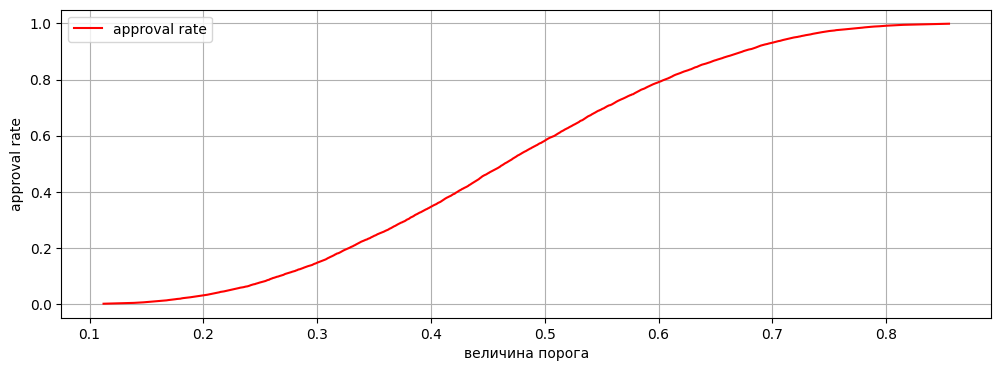

In [34]:
approval_rate_plot(
    model.predict_proba(X_train)[:, 1],
)

## Model perfomance

[к навигации](#Навигация)

### Train perfomance

[к навигации](#Навигация)

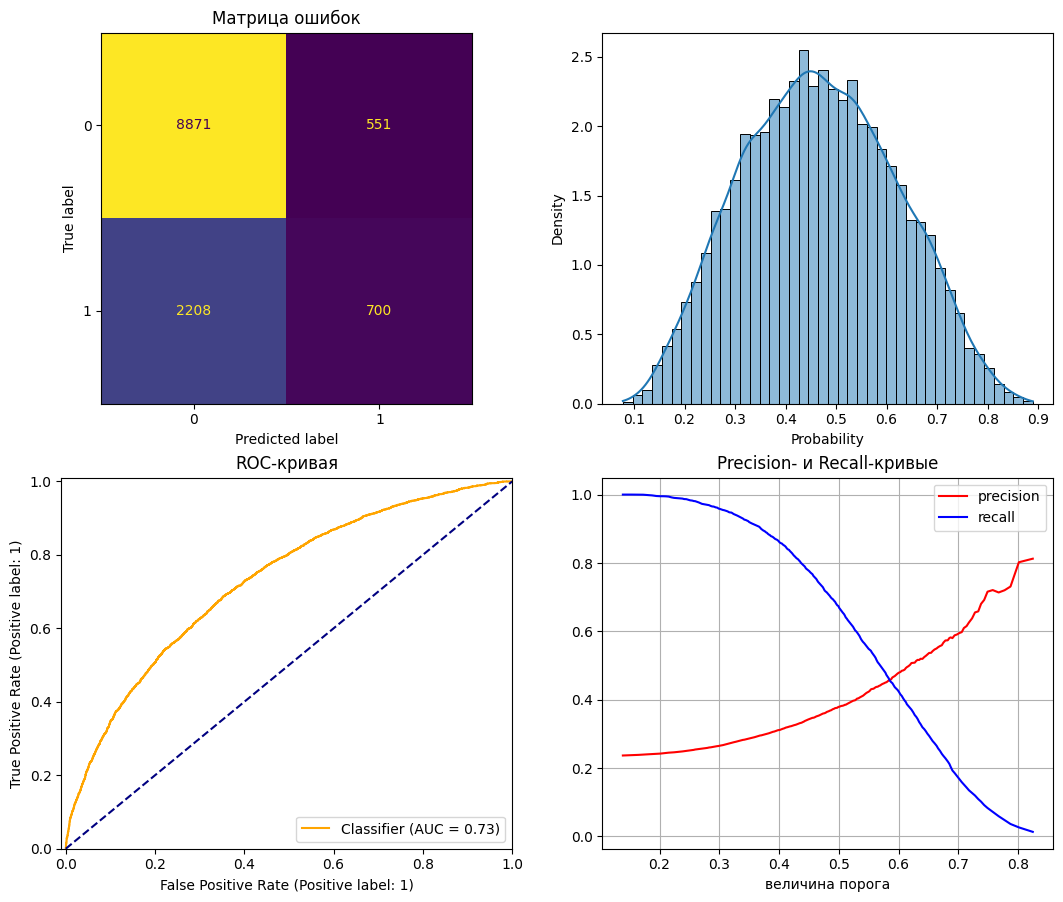

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      9422
           1       0.56      0.24      0.34      2908

    accuracy                           0.78     12330
   macro avg       0.68      0.59      0.60     12330
weighted avg       0.74      0.78      0.74     12330

Индекс Gini = 0.45683512526070125


In [35]:
my_binary_classification_report(
    classifier=model, X=X_train, y_true=y_train, threshold=0.673
)

### Out-of-time perfomance

[к навигации](#Навигация)

#### January

[к навигации](#Навигация)

лучший порог: 0.3277622690001908


0.3277622690001908

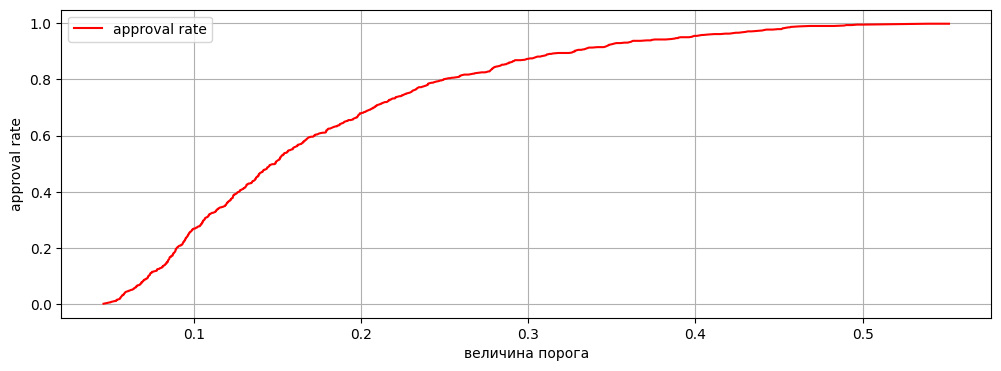

In [26]:
approval_rate_plot(model.predict_proba(X_january)[:, 1])

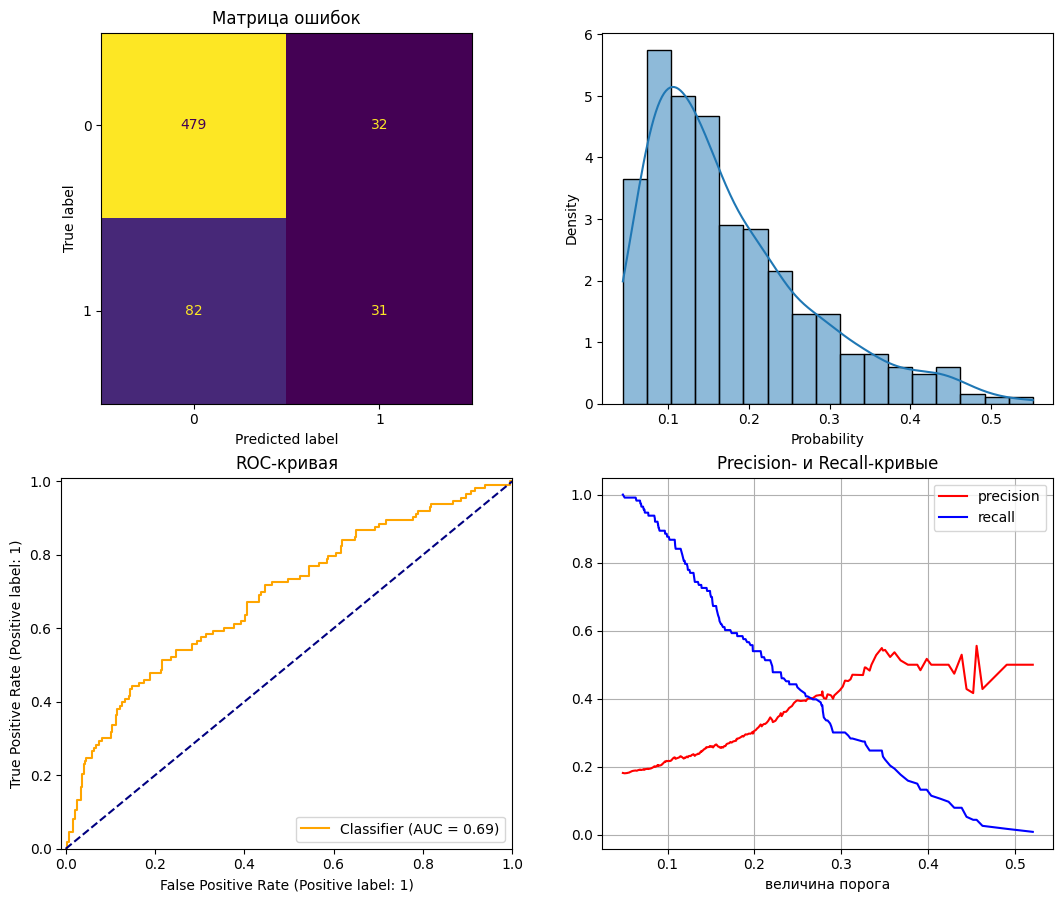

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       511
           1       0.49      0.27      0.35       113

    accuracy                           0.82       624
   macro avg       0.67      0.61      0.62       624
weighted avg       0.79      0.82      0.80       624

Индекс Gini = 0.37488526747830897


In [27]:
my_binary_classification_report(
    classifier=model, X=X_january, y_true=y_january, threshold=0.327
)

#### February

[к навигации](#Навигация)

лучший порог: 0.32168028513354396


0.32168028513354396

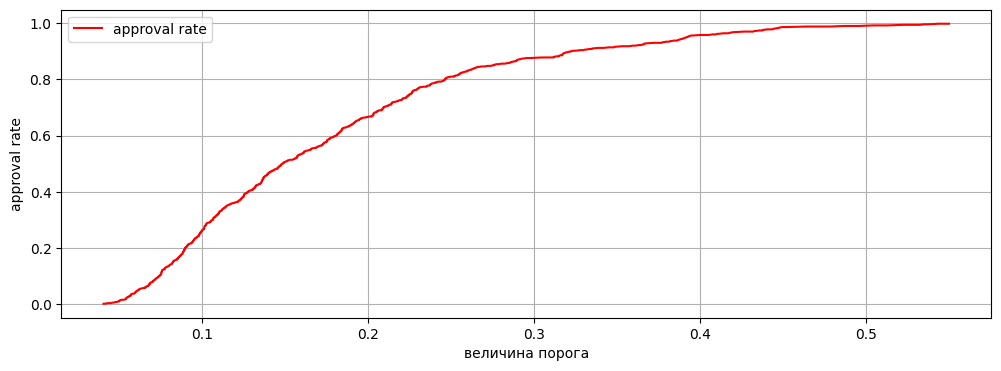

In [28]:
approval_rate_plot(model.predict_proba(X_february)[:, 1])

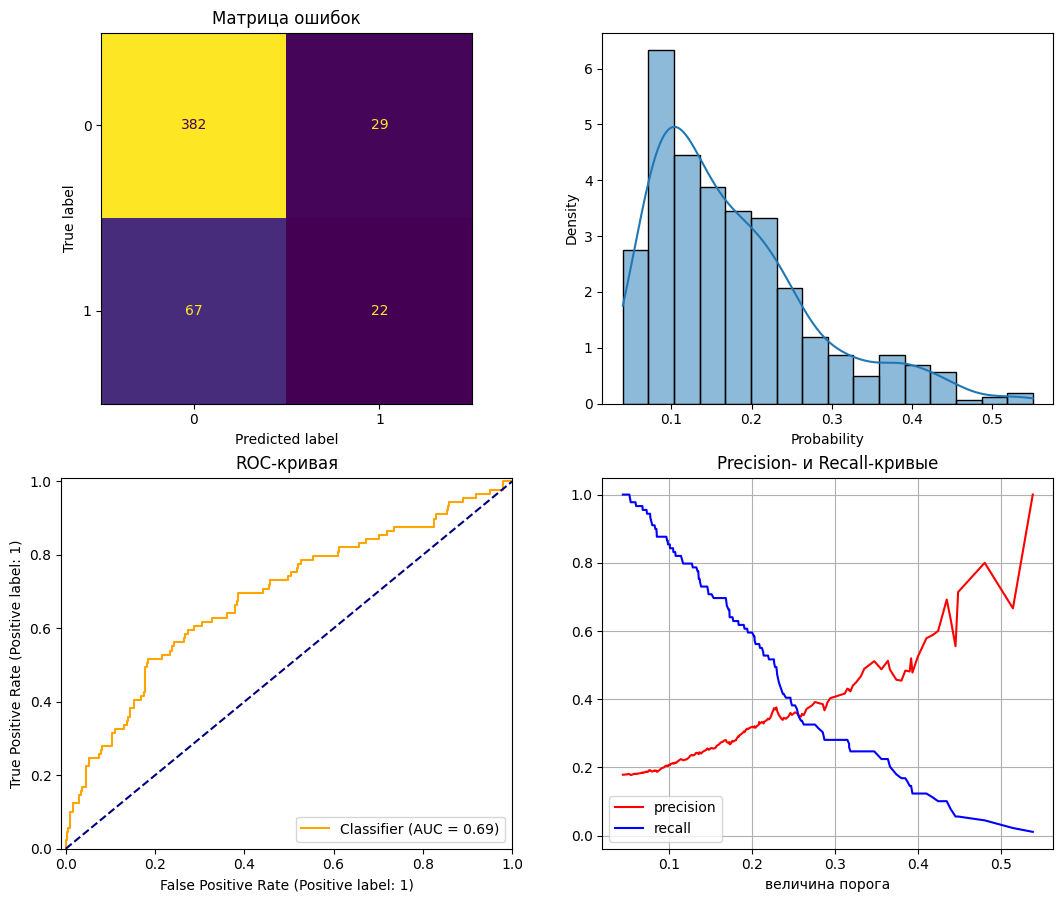

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       411
           1       0.43      0.25      0.31        89

    accuracy                           0.81       500
   macro avg       0.64      0.59      0.60       500
weighted avg       0.78      0.81      0.79       500

Индекс Gini = 0.37362967823067894


In [29]:
my_binary_classification_report(
    classifier=model, X=X_february, y_true=y_february, threshold=0.321
)

#### March

лучший порог: 0.35381996387215525


0.35381996387215525

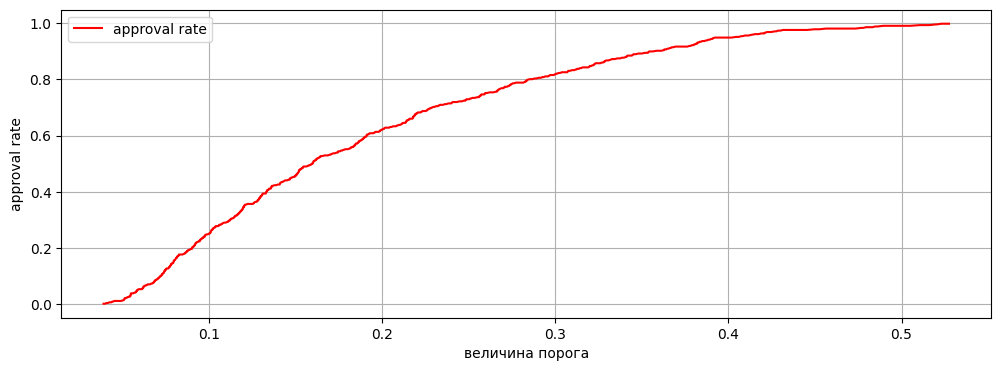

In [30]:
approval_rate_plot(model.predict_proba(X_march)[:, 1])

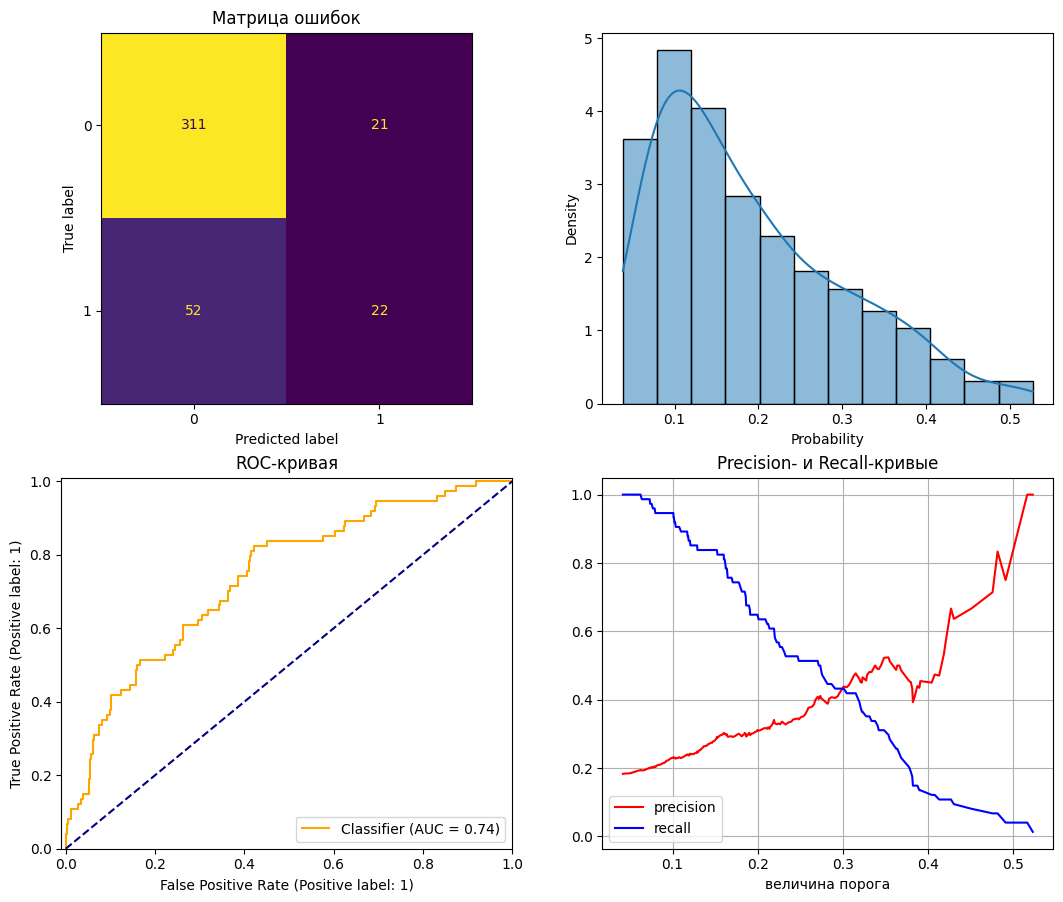

              precision    recall  f1-score   support

           0       0.86      0.94      0.89       332
           1       0.51      0.30      0.38        74

    accuracy                           0.82       406
   macro avg       0.68      0.62      0.64       406
weighted avg       0.79      0.82      0.80       406

Индекс Gini = 0.4757408010420059


In [31]:
my_binary_classification_report(
    classifier=model, X=X_march, y_true=y_march, threshold=0.353
)

## Out of time

лучший порог: 0.6044331908135301


0.6044331908135301

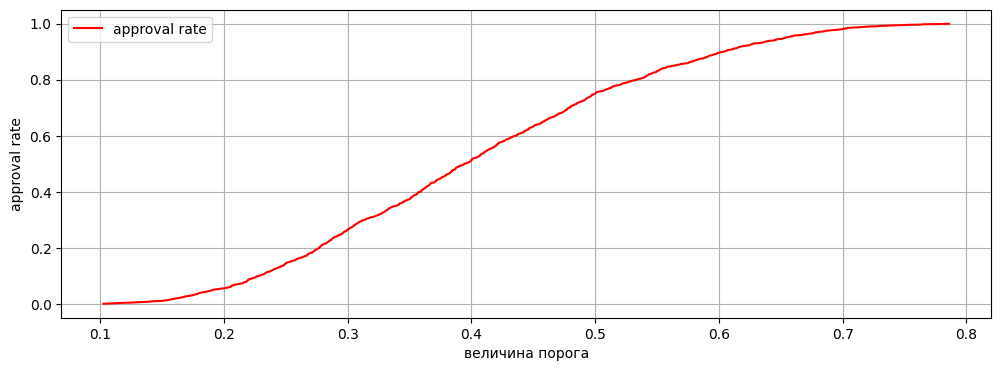

In [36]:
approval_rate_plot(model.predict_proba(X_oot)[:, 1])

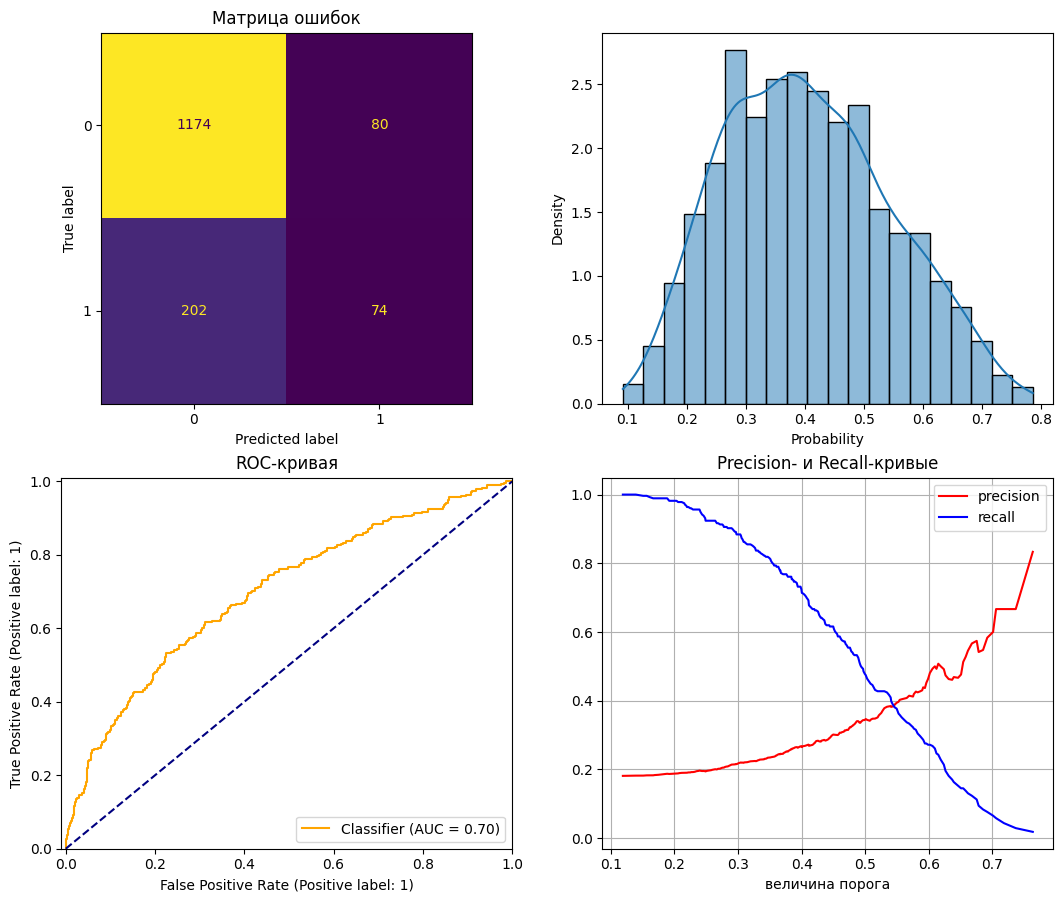

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1254
           1       0.48      0.27      0.34       276

    accuracy                           0.82      1530
   macro avg       0.67      0.60      0.62      1530
weighted avg       0.79      0.82      0.79      1530

Индекс Gini = 0.3960023576728382


In [12]:
my_binary_classification_report(
    classifier=model, X=X_oot, y_true=y_oot, threshold=0.604
)

### Gini OOT STD

In [34]:
all_gini = [0.37488526747830897, 0.37362967823067894, 0.4757408010420059]
round(np.std(all_gini), 2)

0.05

### PSI

In [35]:
psi_df = model[0].transform(X)

In [36]:
psi_df["dtstart"] = X["dtstart"]
psi_df["proba"] = model.predict_proba(X)[:, 1]
psi_df = psi_df.query('"2021-08-01" <= dtstart < "2023-04-01"')

In [37]:
psi_dict = {}
psi_transformer = DropHighPSIFeatures(
    split_col="dtstart",
    cut_off=("2023-01-01"),
    missing_values="ignore",
    variables="all",
)
psi_transformer.fit(psi_df)
psi_dict.update(psi_transformer.psi_values_)

In [38]:
{key: round(psi_dict[key], 2) for key in psi_dict}

{'age': 0.1,
 'dependents': 0.01,
 'DOC': 0.11,
 'averagemonthlyincome': 0.04,
 'Days_since_last_credit': 0.0,
 'Max_overdue': 0.0,
 'Nb_delays_90plus_ever_eq': 0.0,
 'CH_length_eq': 3.14,
 'S_hare_active_credit': 0.57,
 'Score': 0.01,
 'MatchingLevel': 0.01,
 'INTEGRALSCOREValueId': 0.09,
 'LIFETIMEBINValueId': 0.18,
 'requested_amount': 0.09,
 'proba': 0.2,
 'sex': 0.0,
 'sitename': 1.99,
 'citizenshipid': 0.08,
 'martialid': 0.02,
 'day': 0.04,
 'weekday': 0.02,
 'month': 7.75,
 'hour': 0.16}

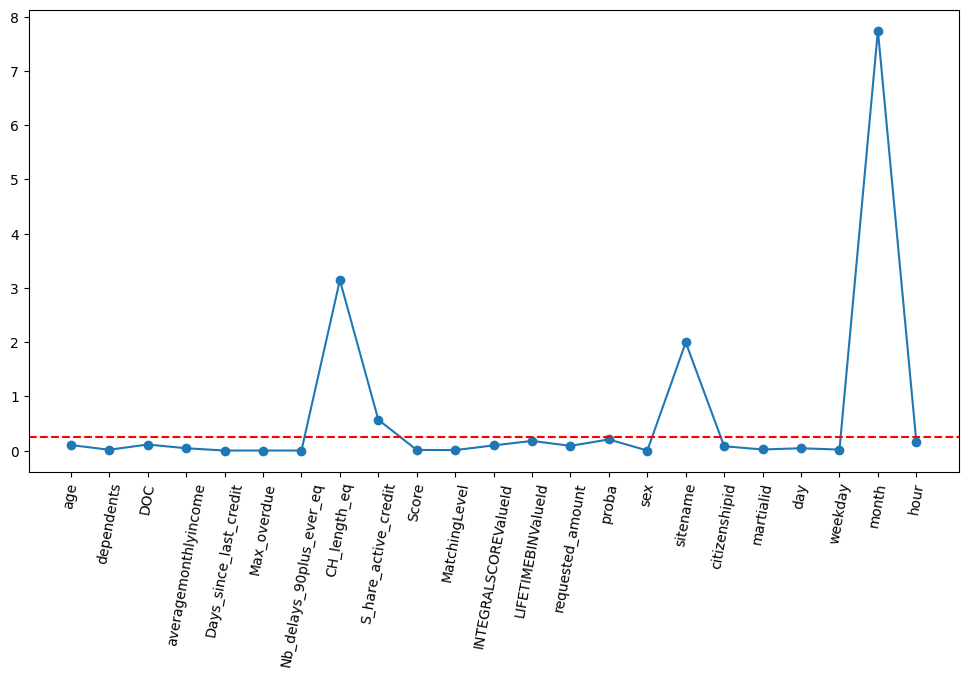

In [39]:
psi_plot(psi_dict.keys(), psi_dict.values(), xy1=(0, 0.25), xy2=(17, 0.25), rotation=80)

In [40]:
my_dict = psi_dict.copy()
del my_dict["CH_length_eq"]
del my_dict["S_hare_active_credit"]
del my_dict["sitename"]
del my_dict["month"]

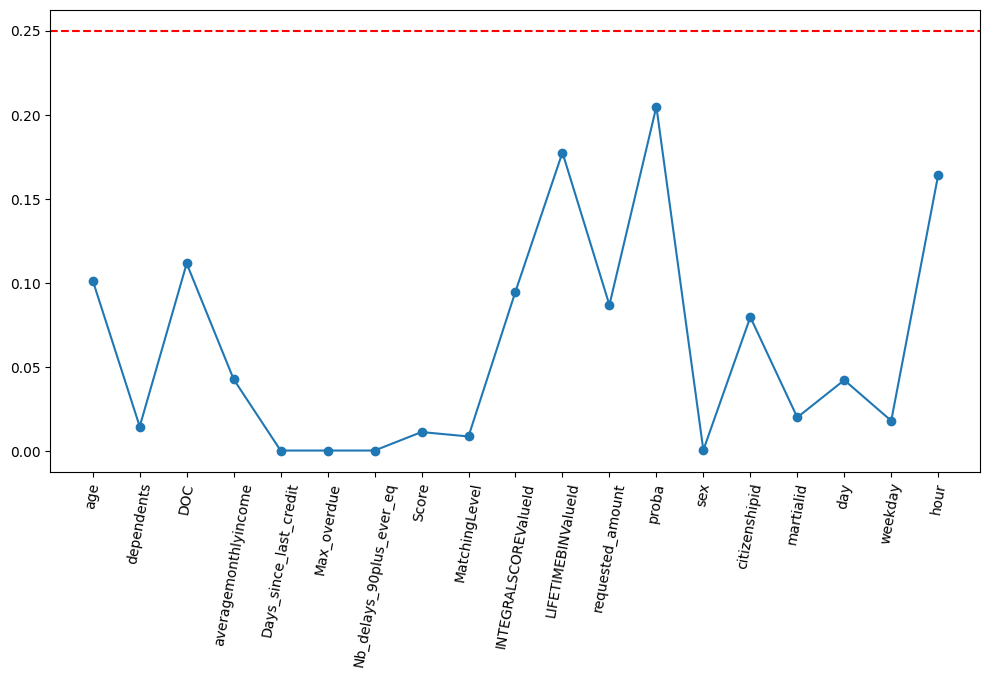

In [41]:
# построим график без выбросов

psi_plot(my_dict.keys(), my_dict.values(), xy1=(0, 0.25), xy2=(17, 0.25), rotation=80)

## SHAP values

[к навигации](#Навигация)

In [43]:
lgbm_model = model.named_steps["LGBM"]
preprocess = model.named_steps["preprocess"]
X_train_shap = preprocess.transform(X_train)
X_jan_shap = preprocess.transform(X_january)
X_feb_shap = preprocess.transform(X_february)
X_march_shap = preprocess.transform(X_march)
X_oot_shap = preprocess.transform(X_oot)

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

In [45]:
cols_dict = {
    "Days_since_last_credit": "NBKI_Days_since_last_credit",
    "Max_overdue": "Max_overdue_eq",
    "S_hare_active_credit": "S_hare_active_credit_eq",
    "Score": "MailRu_Score",
    "MatchingLevel": "MailRu_MatchingLevel",
    "INTEGRALSCOREValueId": "MGFN_INTEGRALSCOREValueId",
    "LIFETIMEBINValueId": "MGFN_LIFETIMEBINValueId",
}

In [42]:
X_train_shap.rename(columns=cols_dict, inplace=True)
X_jan_shap.rename(columns=cols_dict, inplace=True)
X_feb_shap.rename(columns=cols_dict, inplace=True)
X_march_shap.rename(columns=cols_dict, inplace=True)
X_oot_shap.rename(columns=cols_dict, inplace=True)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


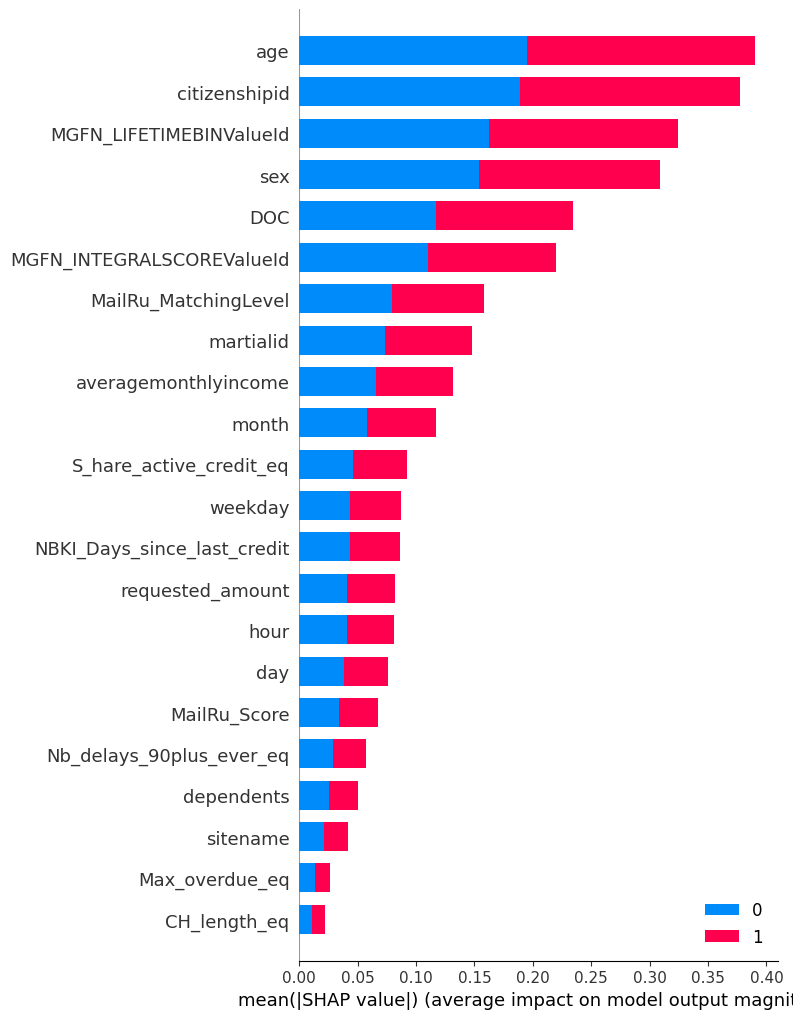

In [43]:
# train
shap.summary_plot(
    shap_values=explainer.shap_values(X_train_shap),
    features=X_train_shap,
    class_names=[0, 1],
    max_display=22,
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


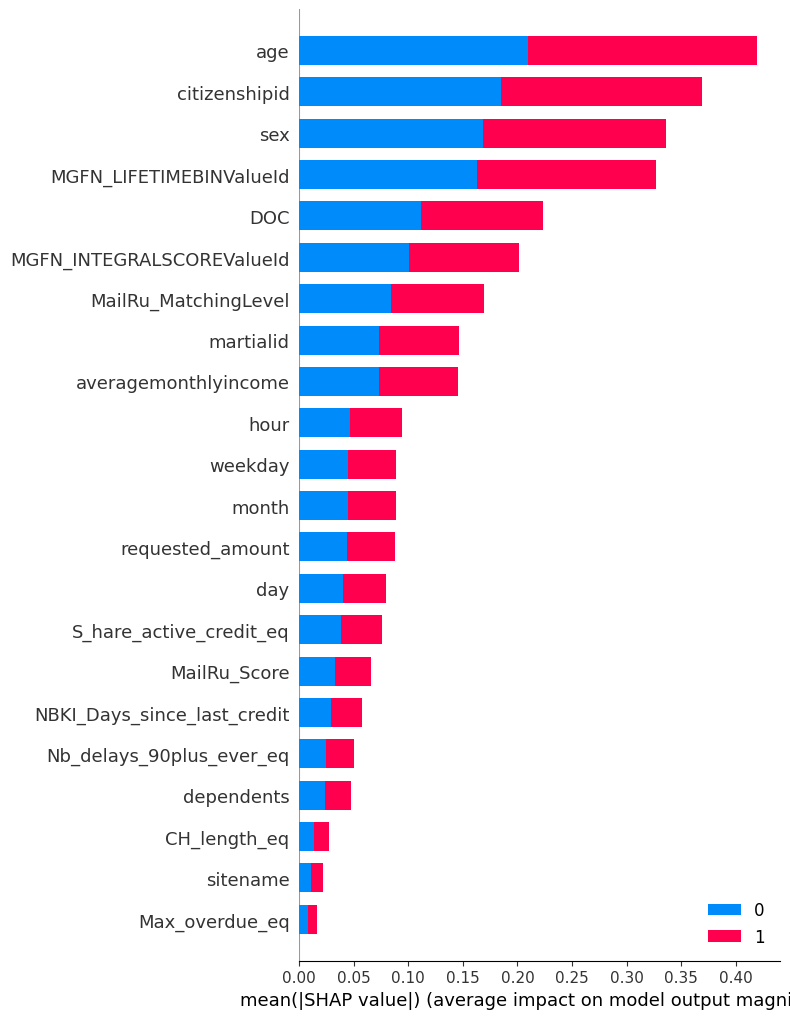

In [44]:
# January

shap.summary_plot(
    shap_values=explainer.shap_values(X_jan_shap),
    features=X_jan_shap,
    class_names=[0, 1],
    max_display=22,
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


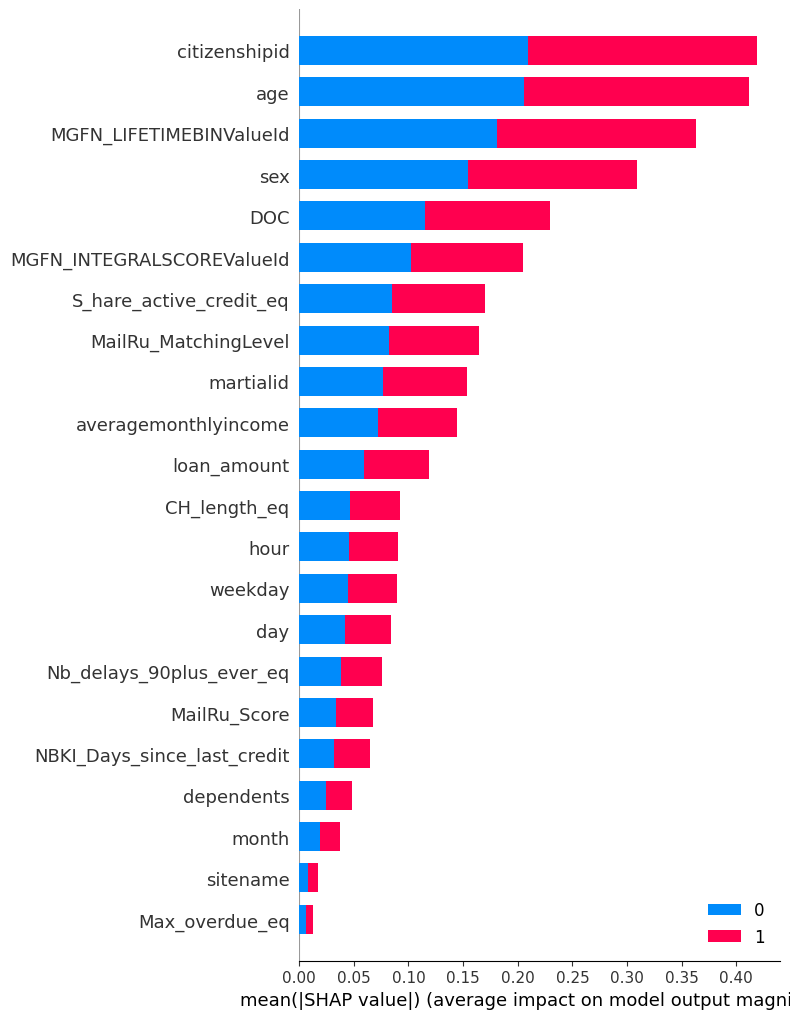

In [34]:
# February

shap.summary_plot(
    shap_values=explainer.shap_values(X_feb_shap),
    features=X_feb_shap,
    class_names=[0, 1],
    max_display=22,
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


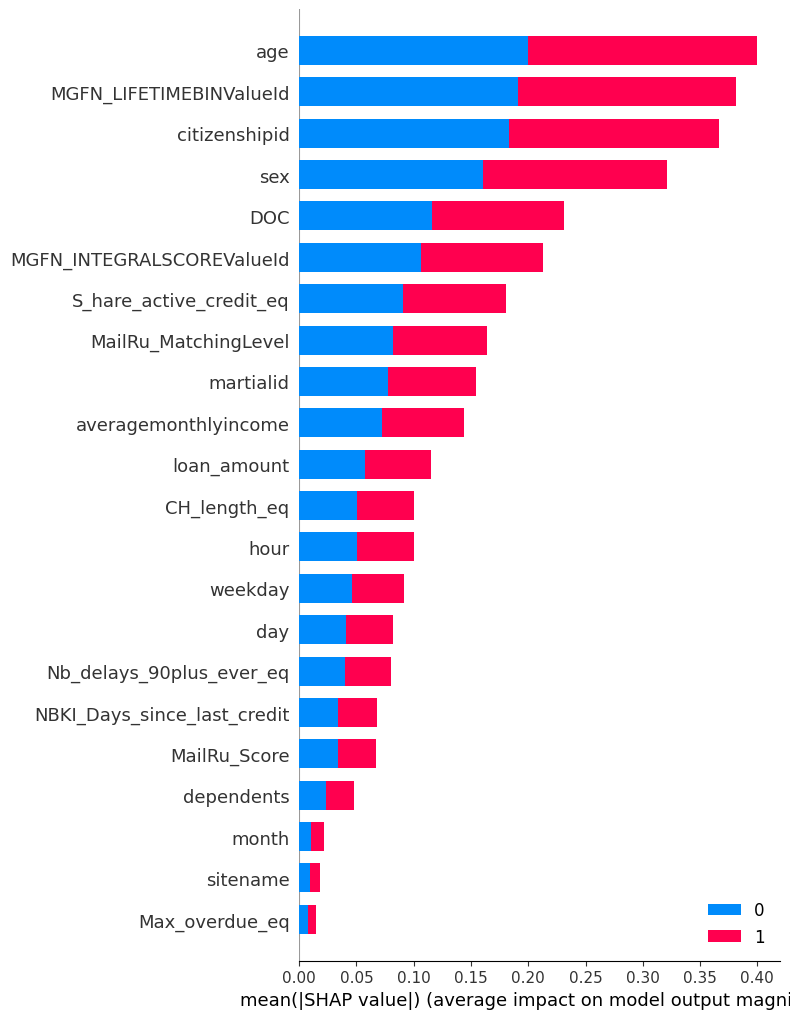

In [35]:
# march

shap.summary_plot(
    shap_values=explainer.shap_values(X_march_shap),
    features=X_march_shap,
    class_names=[0, 1],
    max_display=22,
)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


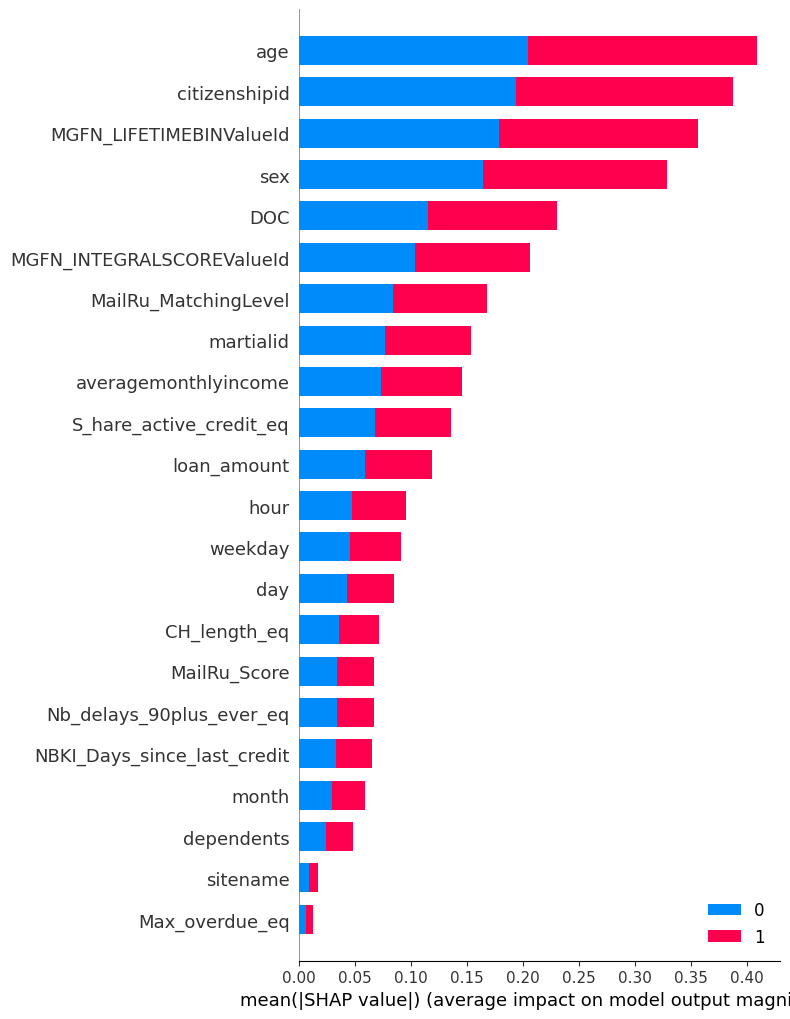

In [36]:
# oot

shap.summary_plot(
    shap_values=explainer.shap_values(X_oot_shap),
    features=X_oot_shap,
    class_names=[0, 1],
    max_display=22,
)

# Вызревшие данные

In [20]:
april_index = data.query('"2023-04-01" <= dtstart < "2023-05-01"').index
may_index = data.query('"2023-05-01" <= dtstart < "2023-06-01"').index
june_index = data.query('"2023-06-01" <= dtstart < "2023-07-01"').index
july_index = data.query('"2023-07-01" <= dtstart < "2023-08-01"').index
august_index = data.query('"2023-08-01" <= dtstart').index
all_new = data.query('"2023-04-01" <= dtstart').index

In [21]:
print(
    f'Размер Aпрельской выборки {april_index.shape[0]} '
    f'(доля дефолтников {data.loc[april_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Майской выборки {may_index.shape[0]} '
    f'(доля дефолтников {data.loc[may_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Июньской выборки {june_index.shape[0]} '
    f'(доля дефолтников {data.loc[june_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Июльской выборки {july_index.shape[0]} '
    f'(доля дефолтников {data.loc[july_index, "60_6mob"].mean():.2%}).\n'
    f'Размер Августовской выборки {august_index.shape[0]} '
    f'(доля дефолтников {data.loc[august_index, "60_6mob"].mean():.2%}).\n'
    f'Размер OOT выборки {all_new.shape[0]} '
    f'(доля дефолтников {data.loc[all_new, "60_6mob"].mean():.2%}).\n'
)

Размер Aпрельской выборки 329 (доля дефолтников 20.36%).
Размер Майской выборки 113 (доля дефолтников 18.58%).
Размер Июньской выборки 112 (доля дефолтников 10.71%).
Размер Июльской выборки 133 (доля дефолтников 19.55%).
Размер Августовской выборки 139 (доля дефолтников 16.55%).
Размер OOT выборки 826 (доля дефолтников 18.04%).



In [22]:
X_new, y_new = get_X_y(data, all_new)
X_april, y_april = get_X_y(data, april_index)
X_may, y_may = get_X_y(data, may_index)
X_june, y_june = get_X_y(data, june_index)
X_july, y_july = get_X_y(data, july_index)
X_august, y_august = get_X_y(data, august_index)

## Все вызревшие

лучший порог: 0.33136478798532293


0.33136478798532293

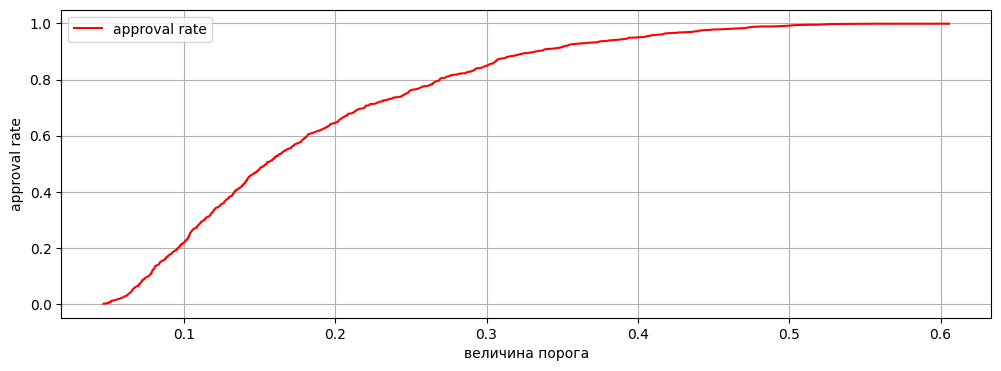

In [23]:
approval_rate_plot(calibrated_model.predict_proba(X_new)[:, 1])

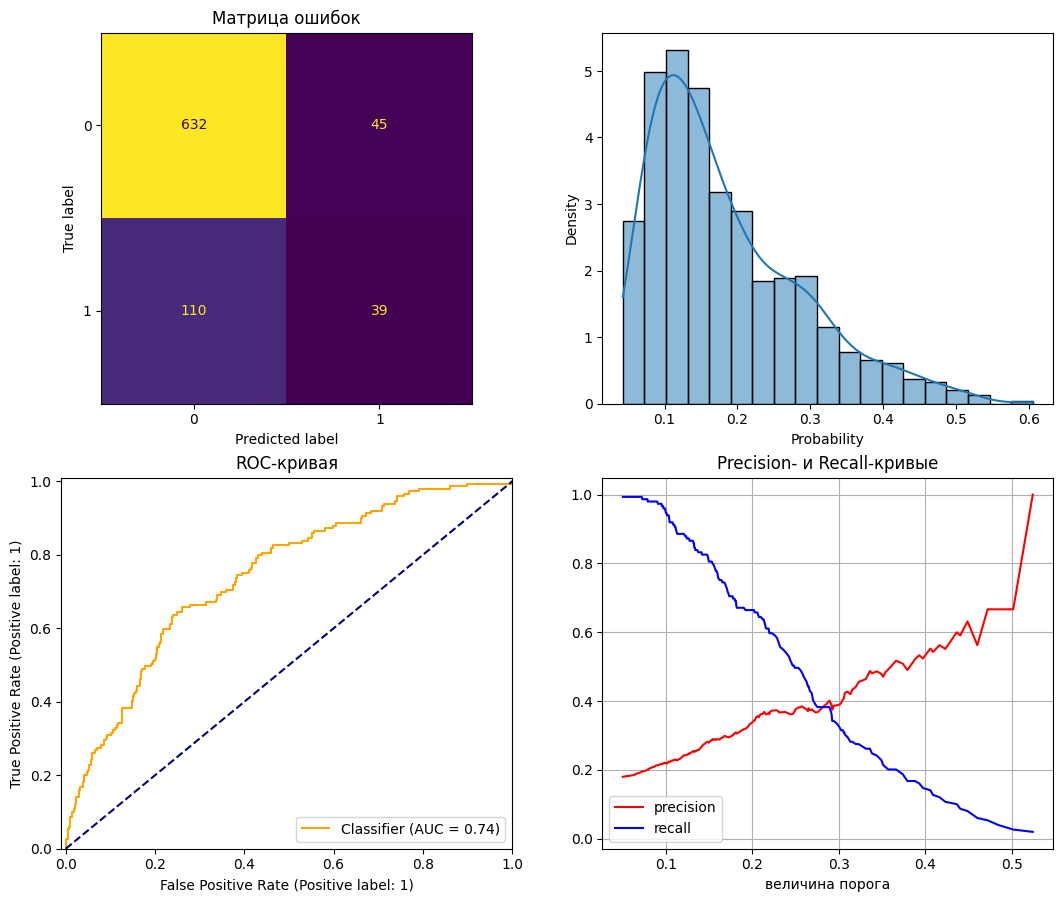

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       677
           1       0.46      0.26      0.33       149

    accuracy                           0.81       826
   macro avg       0.66      0.60      0.61       826
weighted avg       0.78      0.81      0.79       826

Индекс Gini = 0.4835486205426627


In [25]:
my_binary_classification_report(
    classifier=calibrated_model, X=X_new, y_true=y_new, threshold=0.331
)

### April

лучший порог: 0.35322445062388363


0.35322445062388363

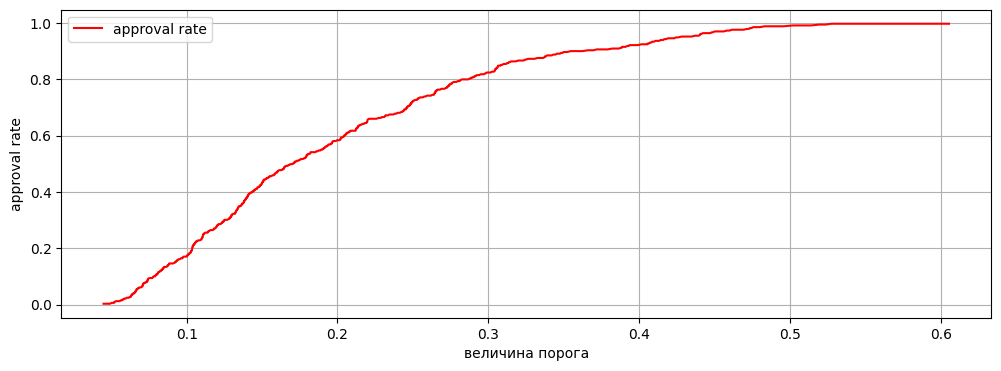

In [26]:
approval_rate_plot(
    calibrated_model.predict_proba(X_april)[:, 1],
)

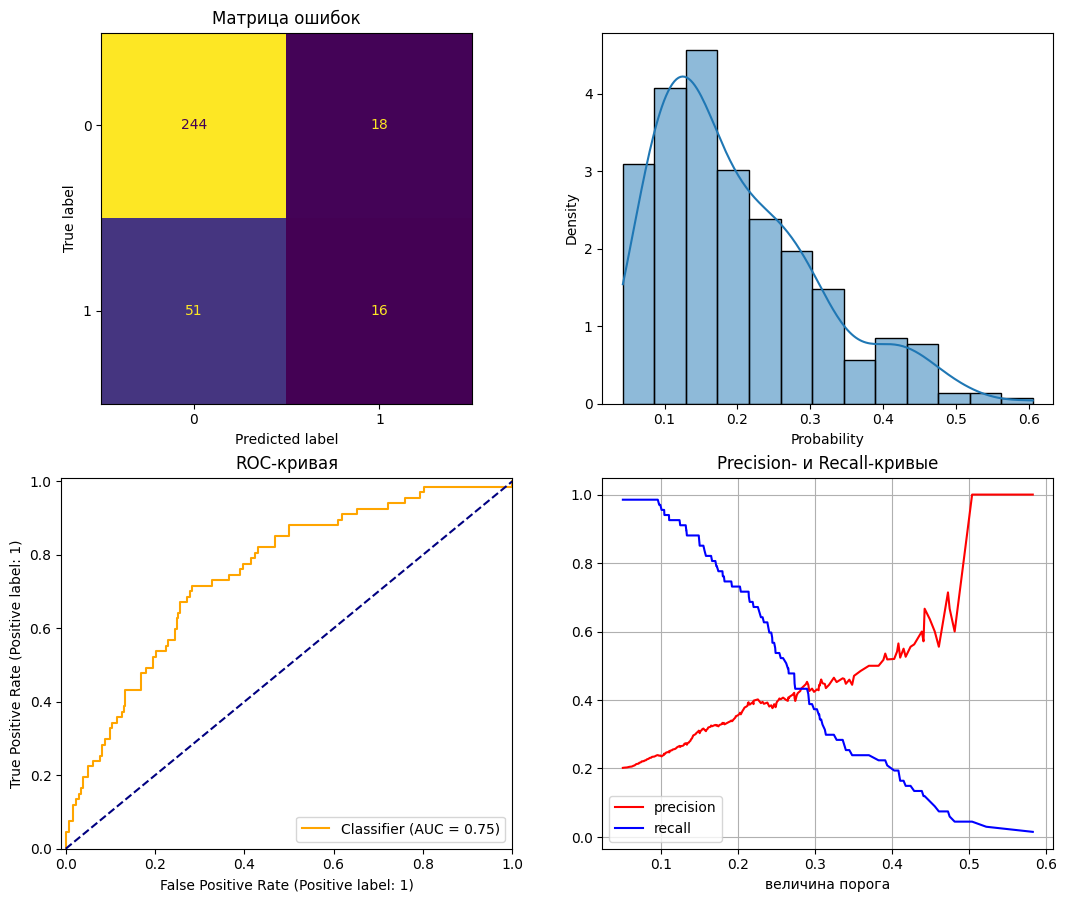

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       262
           1       0.47      0.24      0.32        67

    accuracy                           0.79       329
   macro avg       0.65      0.59      0.60       329
weighted avg       0.75      0.79      0.76       329

Индекс Gini = 0.500284835365159


In [27]:
my_binary_classification_report(
    classifier=calibrated_model, X=X_april, y_true=y_april, threshold=0.353
)

### May

лучший порог: 0.3071346623876741


0.3071346623876741

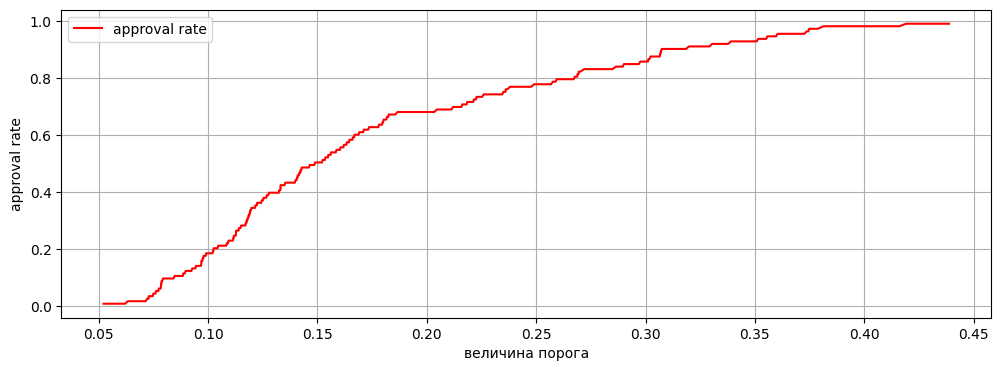

In [28]:
approval_rate_plot(
    calibrated_model.predict_proba(X_may)[:, 1],
)

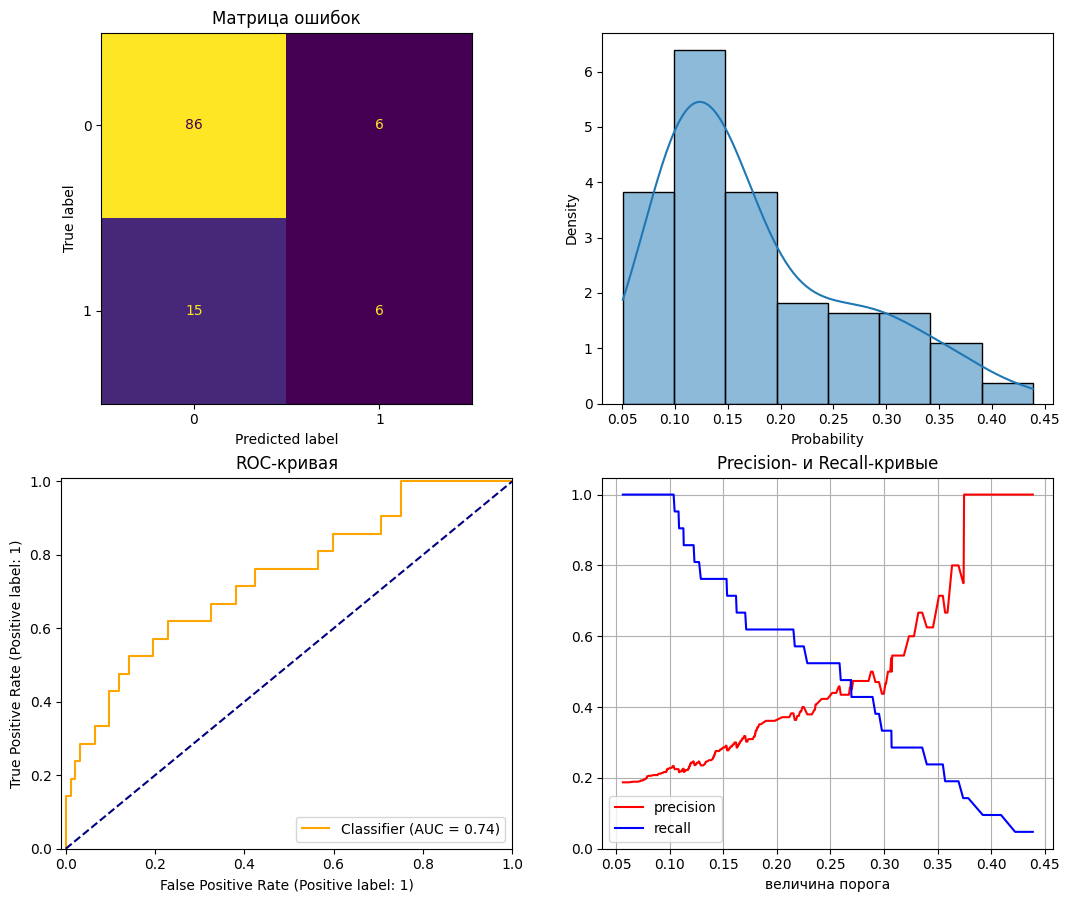

              precision    recall  f1-score   support

           0       0.85      0.93      0.89        92
           1       0.50      0.29      0.36        21

    accuracy                           0.81       113
   macro avg       0.68      0.61      0.63       113
weighted avg       0.79      0.81      0.79       113

Индекс Gini = 0.47515527950310554


In [68]:
my_binary_classification_report(
    classifier=model, X=X_may, y_true=y_may, threshold=0.307
)

### June

лучший порог: 0.3189849456060491


0.3189849456060491

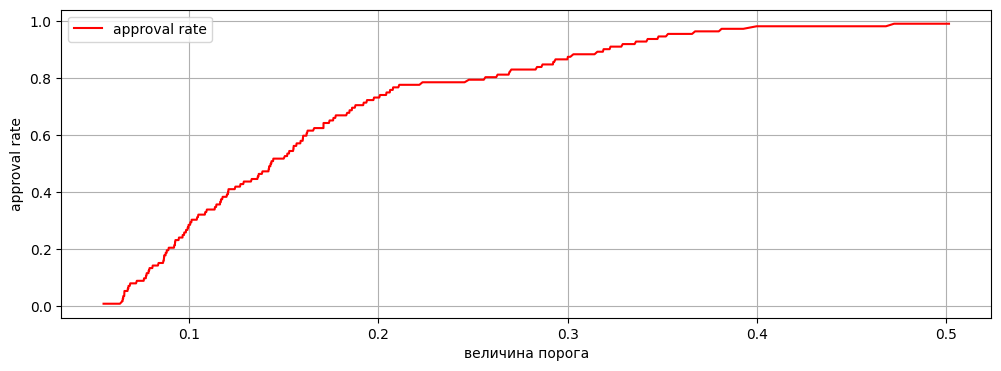

In [69]:
approval_rate_plot(
    model.predict_proba(X_june)[:, 1],
)

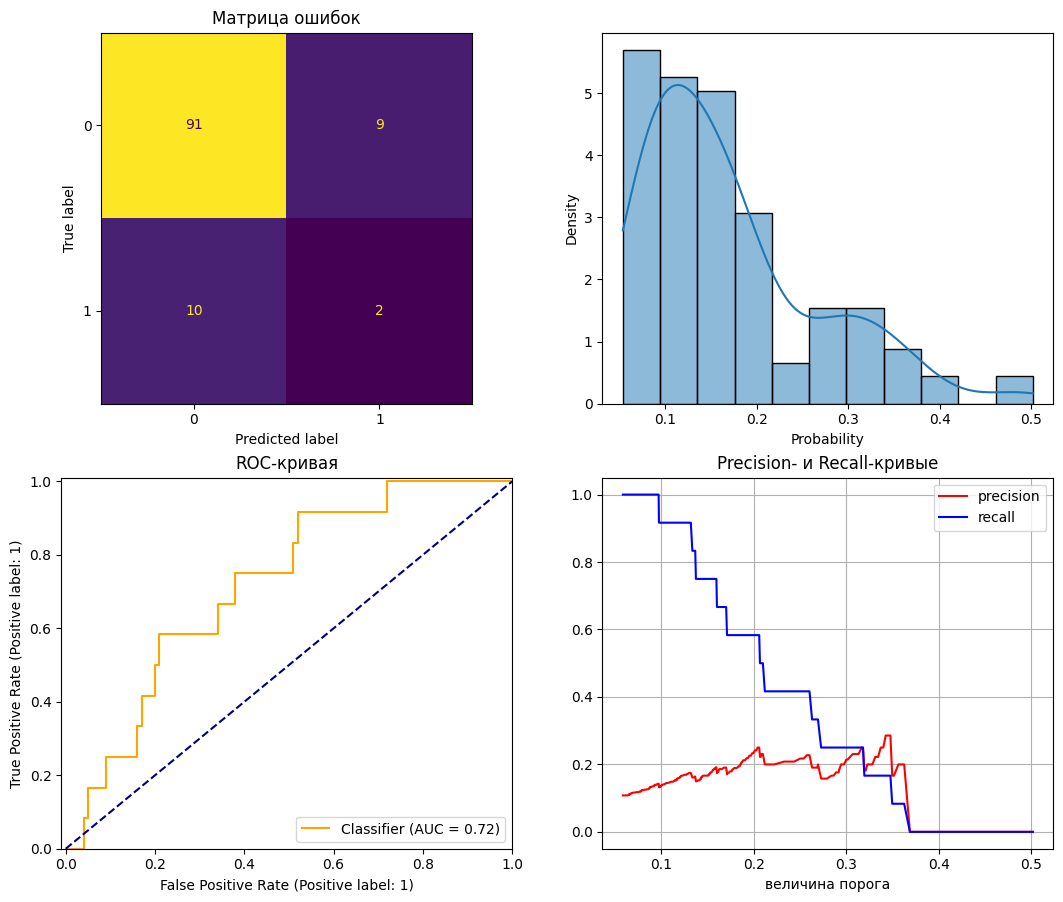

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       100
           1       0.18      0.17      0.17        12

    accuracy                           0.83       112
   macro avg       0.54      0.54      0.54       112
weighted avg       0.82      0.83      0.83       112

Индекс Gini = 0.43500000000000005


In [70]:
my_binary_classification_report(
    classifier=model, X=X_june, y_true=y_june, threshold=0.319
)

### July

лучший порог: 0.33236617681462516


0.33236617681462516

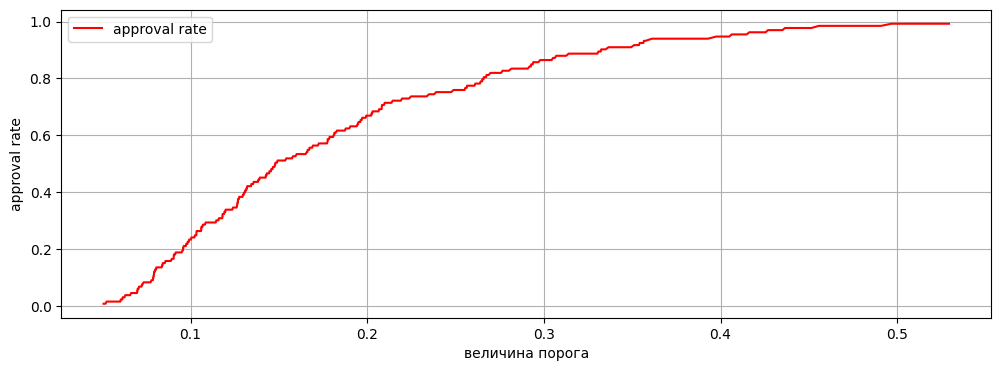

In [71]:
approval_rate_plot(model.predict_proba(X_july)[:, 1])

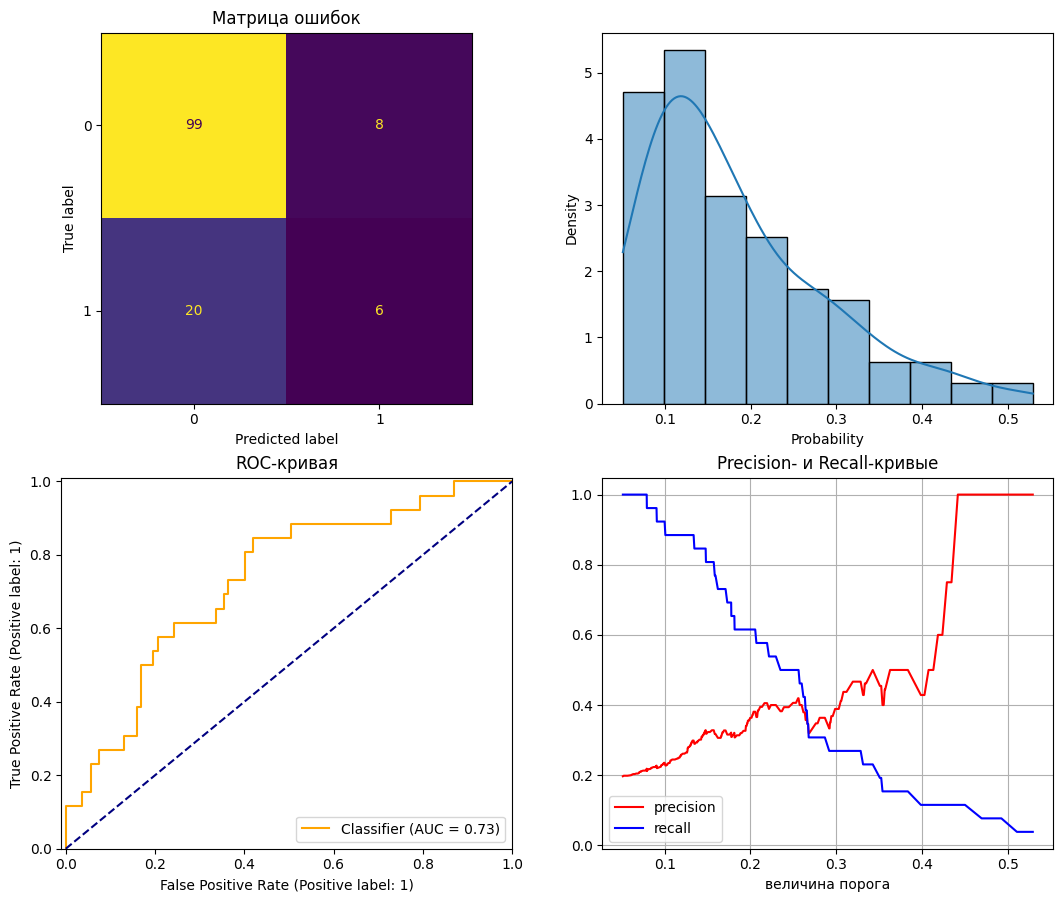

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       107
           1       0.43      0.23      0.30        26

    accuracy                           0.79       133
   macro avg       0.63      0.58      0.59       133
weighted avg       0.75      0.79      0.76       133

Индекс Gini = 0.4615384615384617


In [72]:
my_binary_classification_report(
    classifier=model, X=X_july, y_true=y_july, threshold=0.332
)

### August

лучший порог: 0.31158984815691565


0.31158984815691565

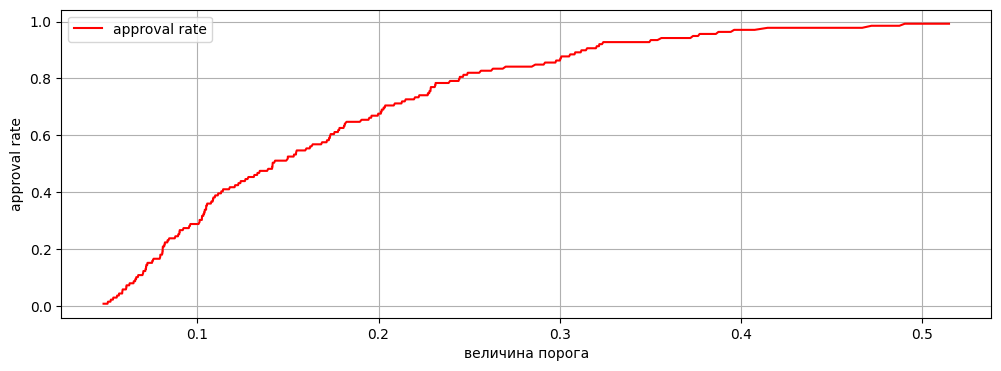

In [73]:
approval_rate_plot(model.predict_proba(X_august)[:, 1])

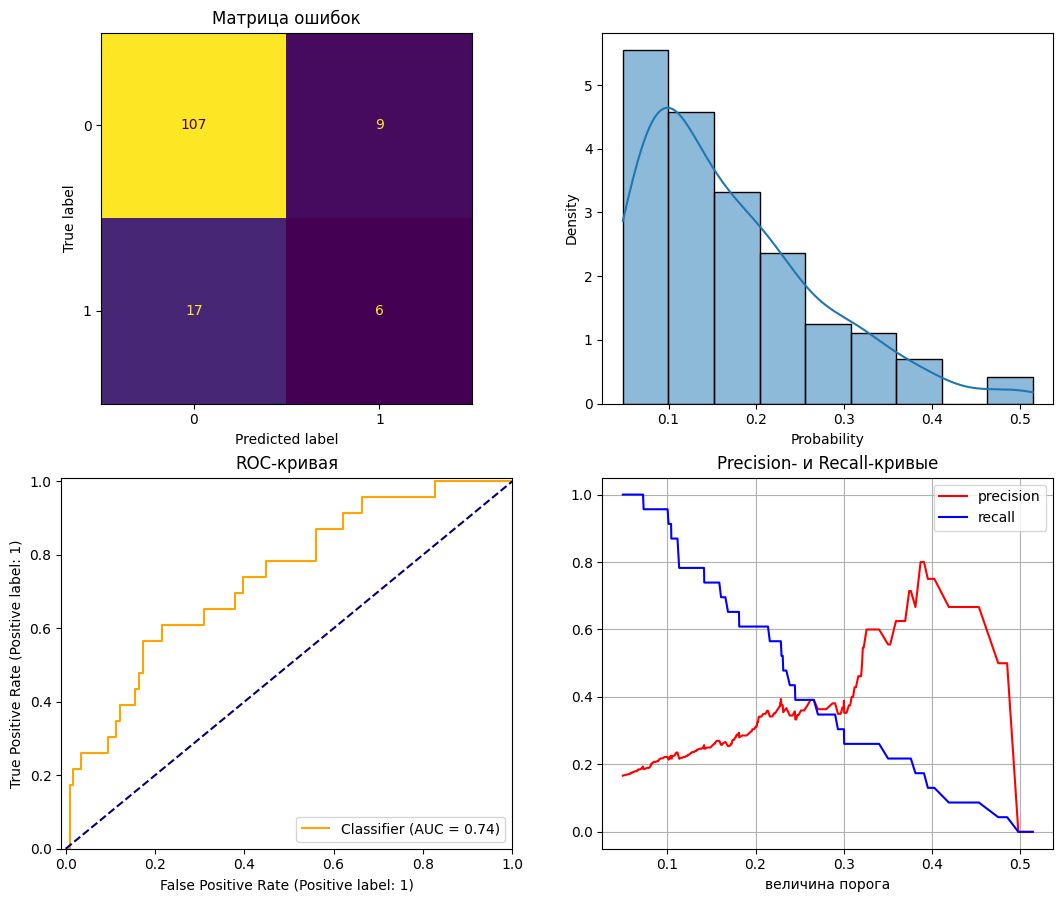

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       116
           1       0.40      0.26      0.32        23

    accuracy                           0.81       139
   macro avg       0.63      0.59      0.60       139
weighted avg       0.79      0.81      0.80       139

Индекс Gini = 0.47301349325337316


In [74]:
my_binary_classification_report(
    classifier=model, X=X_august, y_true=y_august, threshold=0.311
)

## Gini std

In [75]:
new_gini = [
    0.500284835365159,
    0.47515527950310554,
    0.43500000000000005,
    0.4615384615384617,
    0.47301349325337316,
]
round(np.std(new_gini), 2)

0.02

## Shap

In [15]:
X_new_shap = preprocess.transform(X_new)

In [16]:
X_new_shap.rename(columns=cols_dict, inplace=True)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


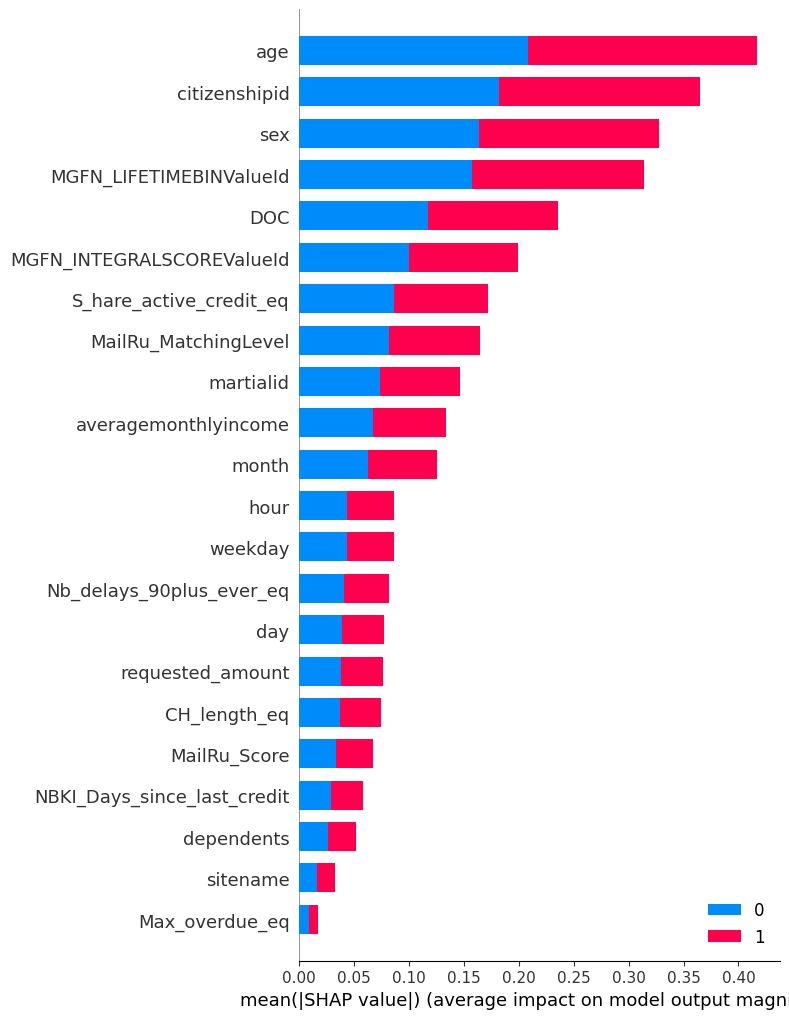

In [17]:
shap.summary_plot(
    shap_values=explainer.shap_values(X_new_shap),
    features=X_new_shap,
    class_names=[0, 1],
    max_display=22,
)